In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import network_util
import data_util
import re

In [25]:
def extract_drug_name(s):
    match = re.search(r'(\D+)', s)
    if match:
        return match.group(1).strip()
    return ""

In [26]:
reimbursed_medicines_path = os.path.join("data", "Refundowane.xlsx")
reimbursed_medicines_df = data_util.preprocess_reimbursed_dataset(reimbursed_medicines_path, "A1", "D,E,L,Q")
display(reimbursed_medicines_df)

,Package,GTIN,Refund_amount
0,30,5909990893423,13.26
1,30,5909990893386,6.64
2,30,5909990109920,3.30
3,60,5909990055715,9.44
4,30,5909991413590,6.33
...,...,...,...
4123,56,5909990681228,208.12
4124,1,5909990189212,15.36
4125,10,5909990189229,153.60
4126,100,5909990126729,22.29


In [27]:
rpl_path = os.path.join("data", "RPL_20240102.csv")
rpl_df = data_util.preprocess_rpl_dataset(rpl_path, [8,13,14,15,16])
display(rpl_df)

,Postać farmaceutyczna,Podmiot odpowiedzialny,Substancja czynna,Nazwa wytwórcy,GTIN
0,Koncentrat do sporządzania roztworu do infuzji,Fresenius Kabi Polska Sp. z o.o.,Acidum zoledronicum 4 mg/5 ml,Fresenius Kabi Austria GmbH,5909991023652
0,Koncentrat do sporządzania roztworu do infuzji,Fresenius Kabi Polska Sp. z o.o.,Acidum zoledronicum 4 mg/5 ml,Fresenius Kabi Austria GmbH,5909991023669
0,Koncentrat do sporządzania roztworu do infuzji,Fresenius Kabi Polska Sp. z o.o.,Acidum zoledronicum 4 mg/5 ml,Fresenius Kabi Austria GmbH,5909991023676
1,Krem,Zakłady Farmaceutyczne POLPHARMA S.A.,Mometasoni furoas 1 mg/g,Glenmark Pharmaceuticals s.r.o.,5909991023683
1,Krem,Zakłady Farmaceutyczne POLPHARMA S.A.,Mometasoni furoas 1 mg/g,Glenmark Pharmaceuticals s.r.o.,5909991023690
...,...,...,...,...,...
21906,Tabletki dopochwowe,Delfarma Sp. z o.o.,Progesteronum 100 mg,NaN,5909991527662
21916,Tabletki,Medezin Sp. z o.o.,tert-Butylamini perindoprilum 8 mg,NaN,5909991527785
21919,Tabletki,Medezin Sp. z o.o.,Cilostazolum 100 mg,NaN,5909991527969
21919,Tabletki,Medezin Sp. z o.o.,Cilostazolum 100 mg,NaN,5909991527976


In [28]:
AVG = "mean"
SUM = "sum"
mode = AVG

In [30]:
merged_df = pd.merge(reimbursed_medicines_df, rpl_df, how="inner", left_on="GTIN", right_on="GTIN")
merged_df = merged_df.rename(
    columns={
        "Postać farmaceutyczna": "Form",
        "Podmiot odpowiedzialny": "Responsible_entity",
        "Substancja czynna": "Substance",
        "Nazwa wytwórcy": "Producer",
    }
)

# Calculate refund amount per unit of medicine and drop obsolete columns
merged_df["Producer"] = merged_df["Producer"].str.replace("\n", " ")
merged_df["Refund_per_unit"] = merged_df["Refund_amount"] / merged_df["Package"]
merged_df["Mean_refund"] = merged_df.groupby(["Form", "Responsible_entity", "Substance"])["Refund_per_unit"].transform("mean")
merged_df.drop(["Refund_amount", "Refund_per_unit", "Package"], axis=1, inplace=True)

# Drop duplicates - drops medicines which are being sold in different sizes
merged_df.drop_duplicates(["Form", "Responsible_entity", "Substance", "Producer", "Mean_refund"], inplace=True)


merged_df['Substance'] = merged_df['Substance'].apply(extract_drug_name)
drugs_without_dosage = merged_df.copy()
drugs_without_dosage['Agg_refund'] = drugs_without_dosage.groupby(["Form", "Responsible_entity", "Substance"])["Mean_refund"].transform(mode)

merged_df = drugs_without_dosage
merged_df.drop(['Mean_refund'],axis = 1, inplace=True)
merged_df.drop_duplicates(["Form", "Responsible_entity", "Substance", "Producer", "Agg_refund"], inplace=True)
display(merged_df)


,GTIN,Form,Responsible_entity,Substance,Producer,Agg_refund
0,5909990893423,Tabletki,Polfarmex S.A.,Acarbosum,Polfarmex S.A.,0.331667
2,5909990109920,Tabletki powlekane,Gedeon Richter Polska Sp. z o.o.,Acebutololi hydrochloridum,Gedeon Richter Polska Sp. z o.o.,0.110000
3,5909990055715,Tabletki,Zakłady Farmaceutyczne POLPHARMA S.A.,Acenocoumarolum,Warszawskie Zakłady Farmaceutyczne POLFA S.A. ...,0.157333
4,5909991413590,Tabletki,Aurovitas Pharma Polska Sp. z o.o.,Aciclovirum,APL Swift Services (Malta) Ltd. Arrow Generiqu...,0.435333
7,5909991049515,Tabletki,Przedsiębiorstwo Produkcji Farmaceutycznej HAS...,Aciclovirum,Przedsiębiorstwo Produkcji Farmaceutycznej HAS...,0.486333
...,...,...,...,...,...,...
4065,5702150155153,Tabletki powlekane,H. Lundbeck A/S,Vortioxetini hydrobromidum,H. Lundbeck A/S,1.659732
4067,5909990622368,Tabletki,Orion Corporation,Warfarinum natricum,Orion Corporation Orion Corporation,0.104850
4071,5909990681228,Kapsułki twarde,"Krka, d.d., Novo mesto",Ziprasidonum,"Krka, d.d., Novo mesto",3.716429
4072,5909990189212,Roztwór do wstrzykiwań,H. Lundbeck A/S,Zuclopenthixoli decanoas,H. Lundbeck A/S,15.360000


In [31]:
merged_df = merged_df.head(10)
G = network_util.create_bipartite_graph(merged_df["Substance"], merged_df['Responsible_entity'], merged_df["Agg_refund"])
pos = network_util.create_bipartite_layout(merged_df["Substance"], merged_df['Responsible_entity'])

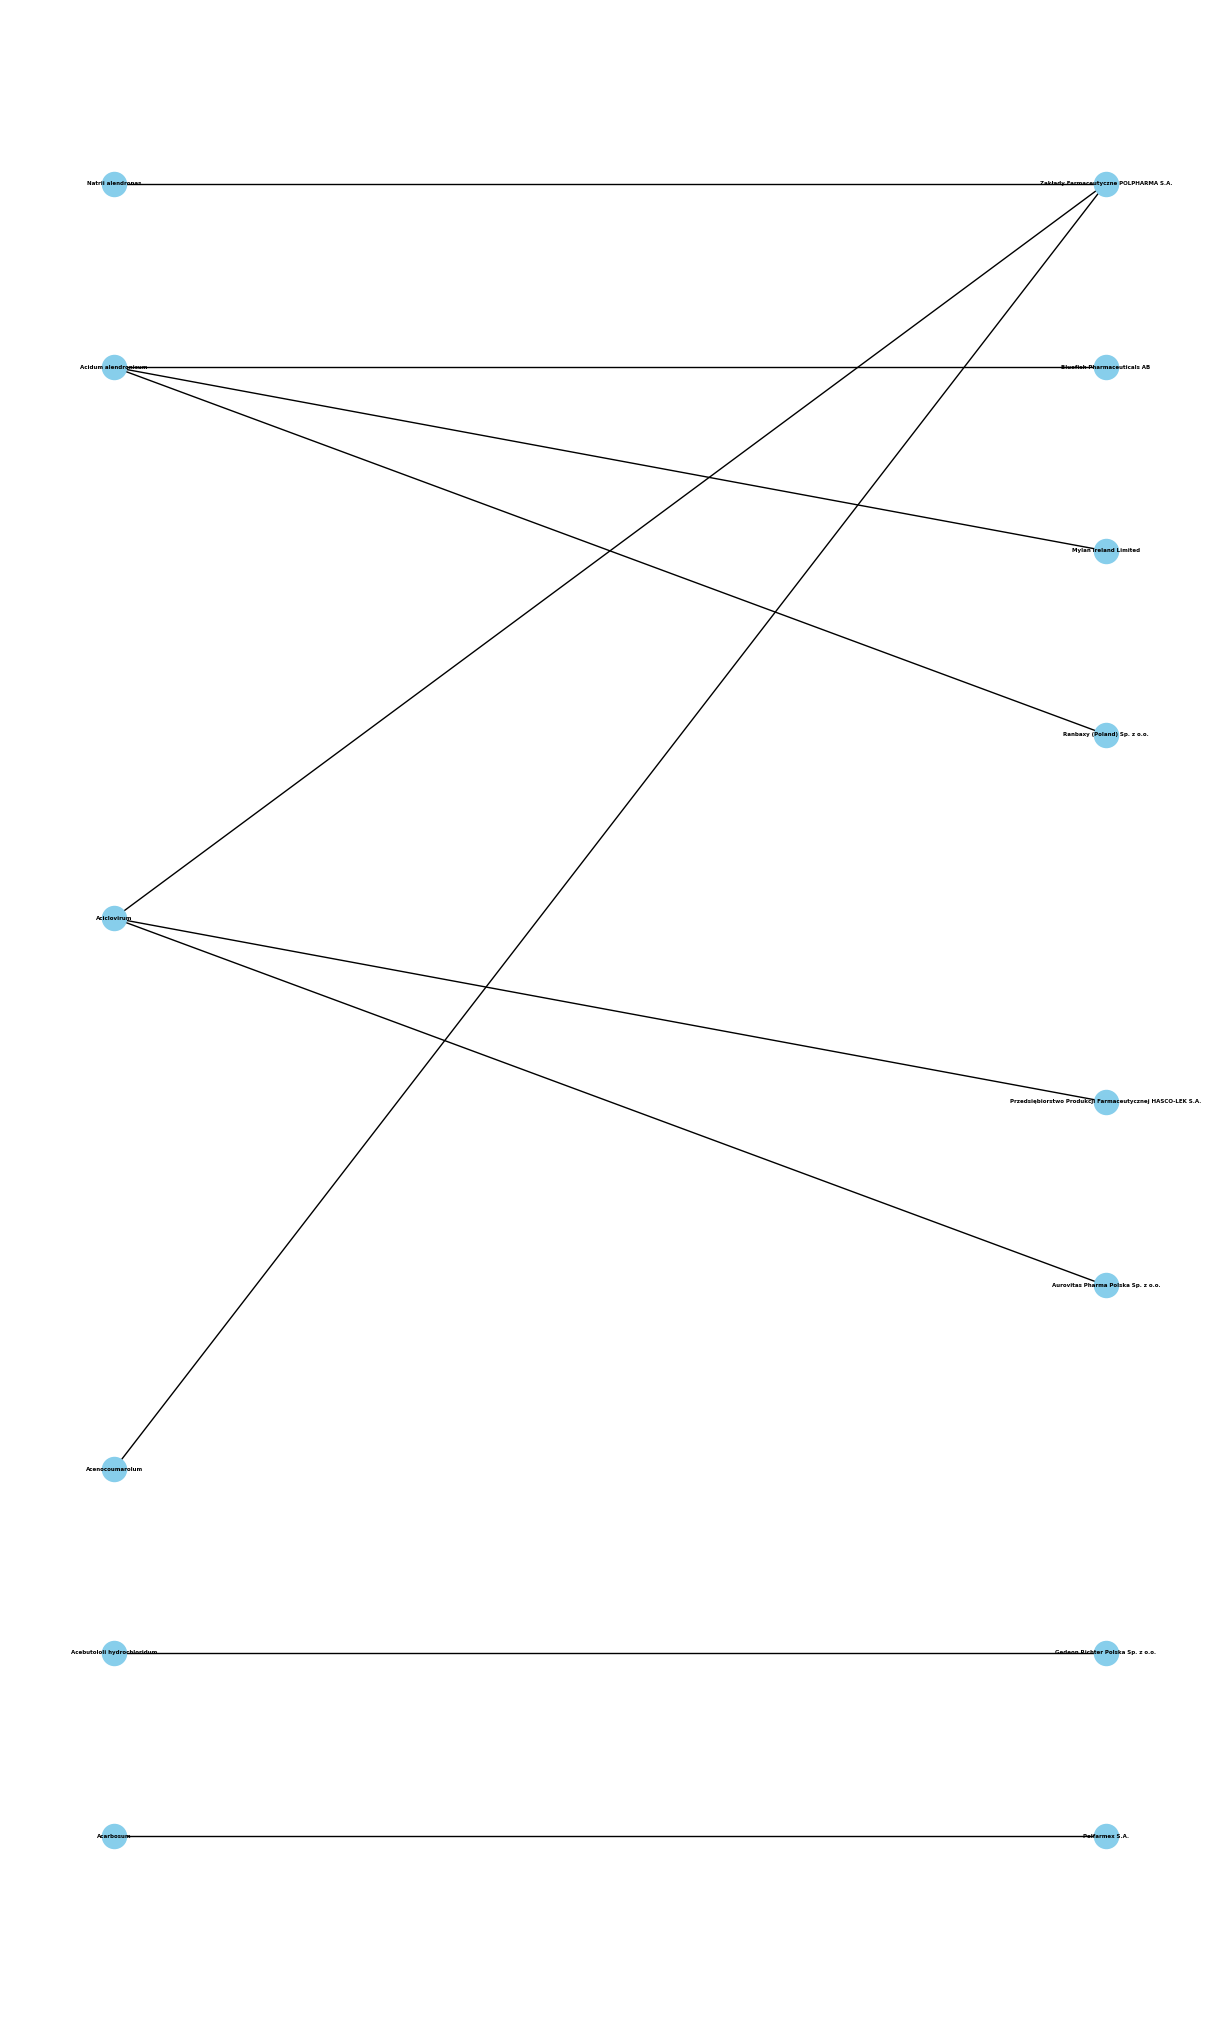

In [32]:
plt.figure(figsize=(12, 20))
nx.draw(G, pos=pos, with_labels=True, font_weight='bold', node_color='skyblue', font_size=4)
plt.show()

In [33]:
top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 1}
print(network_util.sum_node_weights(G, top_nodes, columns=["Entity", "Value"]))

                                              Entity     Value
0                        Ranbaxy (Poland) Sp. z o.o.  2.152500
1                                     Polfarmex S.A.  0.331667
2                   Gedeon Richter Polska Sp. z o.o.  0.110000
3              Zakłady Farmaceutyczne POLPHARMA S.A.  2.837389
4  Przedsiębiorstwo Produkcji Farmaceutycznej HAS...  0.486333
5                        Bluefish Pharmaceuticals AB  1.652500
6                              Mylan Ireland Limited  1.860000
7                 Aurovitas Pharma Polska Sp. z o.o.  0.435333
